<a href="https://colab.research.google.com/github/DarioMameli/DL_Assignments/blob/main/DL_Assignment1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Setup

Firstly let's install and upgrade the necessary packages

In [1]:
!pip install keras --upgrade --quiet
!pip install keras-tuner --upgrade

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 9.7 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow 2.15.0 requires keras<2.16,>=2.15.0, but you have keras 3.0.5 which is incompatible.
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 128.9/128.9 kB 3.7 MB/s eta 0:00:00


Let's import all the necessary functions and packages

In [2]:
import matplotlib.pyplot as plt
import numpy as np

import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import keras
from keras import regularizers
import matplotlib.gridspec as gridspec
from keras.datasets import fashion_mnist
from keras.layers import Dense, Flatten
from keras.models import Sequential
from keras.utils import to_categorical
import keras_tuner as kt
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import layers

from dl_utils import plot_history

from sklearn.metrics import confusion_matrix, classification_report, f1_score, precision_score, recall_score


Check the versions of the packages

In [3]:
print(tf.__version__)
print(keras.__version__)

2.15.0
3.0.5


Check the runtime device

In [4]:
tf.config.list_physical_devices()

[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'),
 PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

# Load data

Load the training and test set and display its shape

In [5]:
(X_train, y_train), (X_test, y_test) = fashion_mnist.load_data()
print(X_train.shape)

29515/29515 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
26421880/26421880 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
5148/5148 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
4422102/4422102 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
(60000, 28, 28)


Show the first instance and corresponding label

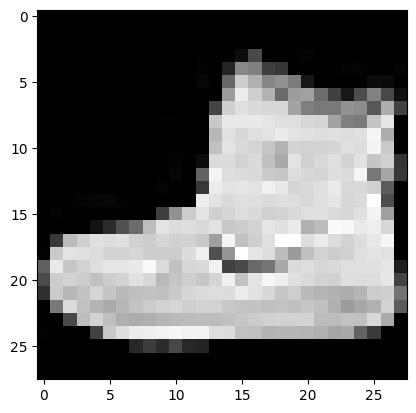

Label = 9


In [6]:
# Show an instance
plt.imshow(X_train[0], cmap="gray")
plt.show()

# Print label
print("Label =", y_train[0])


Preprocess the feature vectors

In [7]:
# Input data preprocessing
print(np.min(X_train), np.max(X_train))
X_train = X_train.astype("float32")
X_test = X_test.astype("float32")

X_train /= 255
X_test /= 255

print(X_train.shape[0], "train samples")
print(X_test.shape[0], "test samples")

0 255
60000 train samples
10000 test samples


Preprocess the labels

In [8]:
# Labels preprocessing
min = np.min(y_train)
max = np.max(y_train)
print(min, max)
num_classes = max + 1

y_train = to_categorical(y_train, num_classes)
y_test = to_categorical(y_test, num_classes)

print("First label is now = ", y_train[0])

0 9
First label is now =  [0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]


# Build the models


## Baseline model
Here we implement the MLP seen in the lab: we use a simple fully connected network here using 8 hidden neurons, followed by another layer of 8 hidden neurons, and finally our output layer. We use the ReLU activation function, except for the output, where we apply a softmax activation as we're doing a multiclass classification here.

This model represents the baseline that we want to improve.

In [9]:
def MLPModel(num_classes):
    model = Sequential()
    model.add(Flatten(input_shape=(28, 28)))
    model.add(Dense(8, activation="relu"))
    model.add(Dense(8, activation="relu"))
    model.add(Dense(num_classes, activation="softmax"))
    model.compile(loss="categorical_crossentropy", metrics=["accuracy"])
    return model

In [10]:
model = MLPModel(num_classes)
model.summary()

/usr/local/lib/python3.10/dist-packages/keras/src/layers/reshaping/flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ flatten (Flatten)                    │ (None, 784)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 8)                   │           6,280 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 8)                   │              72 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 10)                  │              90 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 6,442 (25.16 KB)

 Trainable params: 6,442 (25.16 KB)

 Non-trainable params: 0 (0.00 B)

## Our model

Here we implement our version of the MLP by creating wrapper class for the HyperModel of the Keras Tuner class, in order to perform our custom search via Hyperband algorithm of the best hyperparameters of our model. The hyperparameters we tune are the number of neurons in the two hidden layers, the activation function, the learning rate, the optimizer, and the batch size. We perform data augmentation in the fit function to allow the model to deal with different image transformations. We split the training data into a training and validation set to improve the generalization.

In [13]:
class MyMLPModel(kt.HyperModel):
  # build function to override
  def build(self, hp):
        model = self.build_MLP(hp)
        return model

  # Sets up the hyperparameters and calls the actual building model function
  def build_MLP(self, hp):
      # Tune the number of units for the Dense layers
      hp_units1 = hp.Int('unitsL1', min_value=32, max_value=512, step=32)
      hp_units2 = hp.Int('unitsL2', min_value=32, max_value=512, step=32)

      # Choose the activation function for the Dense layers
      hp_activation = hp.Choice("activation", ["relu", "tanh"])

      # Tune the learning rate for the optimizer
      hp_learning_rate = hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4])

      # Choose the optimizer
      hp_optimizer = hp.Choice('optimizer', values=['sgd', 'adam'])

      # call existing model-building code with the hyperparameter values.
      model = self.build_MLP_hp(
          hp_units1=hp_units1, hp_units2=hp_units2, hp_activation=hp_activation,
          hp_learning_rate=hp_learning_rate, hp_optimizer=hp_optimizer
      )
      return model

  # Builds the model given the parameters
  def build_MLP_hp(self, hp_units1, hp_units2, hp_activation, hp_learning_rate,
                   hp_optimizer):
      model = Sequential()
      model.add(Flatten(input_shape=(28, 28)))
      model.add(Dense(units=hp_units1, activation=hp_activation))
      model.add(Dense(units=hp_units2, activation=hp_activation))
      model.add(Dense(10, activation="softmax"))

      # Check which is the optimizer for the hyperparameter
      if hp_optimizer == 'sgd':
          optimizer = keras.optimizers.SGD(learning_rate=hp_learning_rate)
      elif hp_optimzier == 'adam':
          optimizer = keras.optimizers.Adam(learning_rate=hp_learning_rate)
      else:
          raise

      # Compile the model with the given hyperparameters
      model.compile(optimizer=optimizer,
                    loss="categorical_crossentropy", metrics=["accuracy"])
      return model

  # fit function to override
  def fit(self, hp, model, *args, **kwargs):
        # Initialize ImageDataGenerator for data augmentation specifying a bunch of different transformations
        datagen = ImageDataGenerator(
            rotation_range=10,
            width_shift_range=0.1,
            height_shift_range=0.1,
            shear_range=0.2,
            zoom_range=0.2,
            horizontal_flip=True,
            vertical_flip = True,
            fill_mode='nearest',
            validation_split=0.2
        )
        # Retrieve the training data
        X_train = args[0]
        # Increase the dimensionality of the data for datagen
        X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], X_train.shape[2], 1)
        # Fit the data generator on the training data
        datagen.fit(X_train)
        # Tune the batch size
        hp_batch_size = hp.Choice('batch_size', values=[16, 32, 64, 128, 256])
        # Use the generator to augment the data during training
        return model.fit(
        datagen.flow(X_train, y_train, batch_size=hp_batch_size, shuffle=True, subset='training'), # Use augmentation on the training set
        validation_data=datagen.flow(X_train, y_train, subset='validation'),  # Use augmentation on the validation set
        )

The hyperband tuner object allows to perform the search of the hyperparameters using hyperband algorithm.

In [14]:
# Define the hyperband tuner object, passing the model where to perform the search
tuner = kt.Hyperband(MyMLPModel(),
                     objective='val_accuracy',
                     max_epochs=10,
                     #overwrite = True,
                     max_consecutive_failed_trials=5,
                     project_name='my_mlp_tuning',
                     directory='my_mlp_tuning',
)
# Summarize the search space
tuner.search_space_summary()

Search space summary
Default search space size: 5
unitsL1 (Int)
{'default': None, 'conditions': [], 'min_value': 32, 'max_value': 512, 'step': 32, 'sampling': 'linear'}
unitsL2 (Int)
{'default': None, 'conditions': [], 'min_value': 32, 'max_value': 512, 'step': 32, 'sampling': 'linear'}
activation (Choice)
{'default': 'relu', 'conditions': [], 'values': ['relu', 'tanh'], 'ordered': False}
learning_rate (Choice)
{'default': 0.01, 'conditions': [], 'values': [0.01, 0.001, 0.0001], 'ordered': True}
optimizer (Choice)
{'default': 'sgd', 'conditions': [], 'values': ['sgd', 'adam'], 'ordered': False}


# Training


## Baseline's training

Here we train the baseline model using the same parameters specified in the lab.

Epoch 1/5
375/375 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - accuracy: 0.4119 - loss: 1.6292 - val_accuracy: 0.7728 - val_loss: 0.7184
Epoch 2/5
375/375 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.7939 - loss: 0.6602 - val_accuracy: 0.8130 - val_loss: 0.5585
Epoch 3/5
375/375 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8216 - loss: 0.5385 - val_accuracy: 0.8278 - val_loss: 0.5105
Epoch 4/5
375/375 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.8294 - loss: 0.5023 - val_accuracy: 0.8353 - val_loss: 0.4917
Epoch 5/5
375/375 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.8375 - loss: 0.4718 - val_accuracy: 0.8268 - val_loss: 0.4933


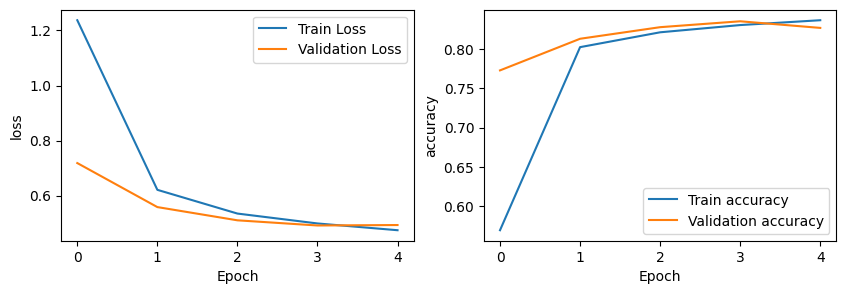

In [15]:
batch_size = 128
epochs = 5

# Fit the model
history = model.fit(X_train, y_train, batch_size=batch_size, epochs=epochs, verbose=1, validation_split=0.2)
plot_history(history)

Save the baseline model in the workspace

In [25]:
model.save('/content/baseline_model.keras')

## Training the best model

Here we first perform the search of the best parameters using the hyperband tuner previously defined, then we train the best model with a train-validation split. We specify a high number of epochs because the early stopping function allows to stop the training by monitoring the validation loss, to prevent overfitting.

Trial 22 Complete [00h 00m 00s]

Best val_accuracy So Far: 0.6230833530426025
Total elapsed time: 00h 07m 39s
Epoch 1/50
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - accuracy: 0.6902 - loss: 1.0027 - val_accuracy: 0.8105 - val_loss: 0.5469
Epoch 2/50
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.8247 - loss: 0.5101 - val_accuracy: 0.8332 - val_loss: 0.4705
Epoch 3/50
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.8477 - loss: 0.4451 - val_accuracy: 0.8468 - val_loss: 0.4328
Epoch 4/50
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - accuracy: 0.8532 - loss: 0.4193 - val_accuracy: 0.8470 - val_loss: 0.4354
Epoch 5/50
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - accuracy: 0.8584 - loss: 0.3970 - val_accuracy: 0.8591 - val_loss: 0.3984
Epoch 6/50
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.8700 - loss: 0.3728 - val_accuracy: 0.8643 - val_loss: 0.3882
Epoch 7/50
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.8736 - loss: 0.3611 - val_accuracy: 0.8673

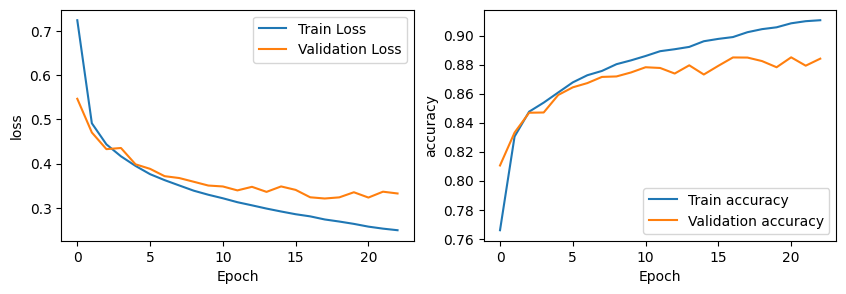

Best epoch: 21


In [16]:
# Early stop to prevent overfitting
stop_early = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)

# Perform the search
tuner.search(X_train, y_train, callbacks=[stop_early])

# Get the optimal hyperparameters
best_hps=tuner.get_best_hyperparameters(num_trials=1)[0]

# Build the model with the optimal hyperparameters and train it on the data for 50 epochs
best_model = tuner.hypermodel.build(best_hps)
history = best_model.fit(X_train, y_train, epochs=50, validation_split=0.2, callbacks=[stop_early])

plot_history(history)

val_acc_per_epoch = history.history['val_accuracy']
best_epoch = np.argmax(val_acc_per_epoch) + 1
print('Best epoch: %d' % (best_epoch,))

Save the best model in the workspace

In [26]:
best_model.save('/content/best_model.keras')

# Evaluation

## Baseline evaluation

Print the scores of the trained baseline model.

In [17]:
base_score = model.evaluate(X_test, y_test, verbose=0)

print("Baseline model")
print("Test loss:", base_score[0])
print("Test accuracy:", base_score[1])

Baseline model
Test loss: 0.5211422443389893
Test accuracy: 0.8169000148773193


## Best model evaluation

Print the scores of the best model.
Print the increment in the test set's accuracy.

In [18]:
best_score = best_model.evaluate(X_test, y_test, verbose=0)

print("Best model")
print("Best parameters:", best_hps.values)
print("Test loss:", best_score[0])
print("Test accuracy:", best_score[1])
print("Test accuracy improvement:", 100*(best_score[1]-base_score[1])/base_score[1], "%")

Best model
Best parameters: {'unitsL1': 448, 'unitsL2': 256, 'activation': 'relu', 'learning_rate': 0.01, 'optimizer': 'sgd', 'batch_size': 16, 'tuner/epochs': 4, 'tuner/initial_epoch': 0, 'tuner/bracket': 1, 'tuner/round': 0}
Test loss: 0.3579557240009308
Test accuracy: 0.8720999956130981
Test accuracy improvement: 6.757250548473628 %


## Best and worst predictions

Here we plot the 5 best and 5 worst predictions and make some hypotheses on the reasons.

1875/1875 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step


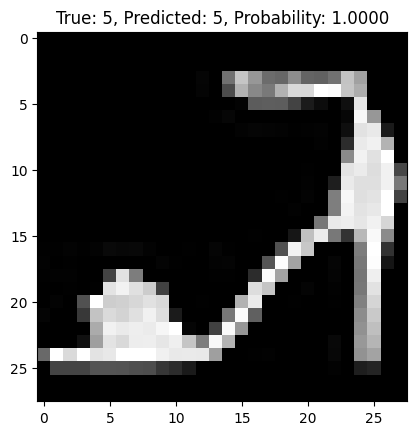

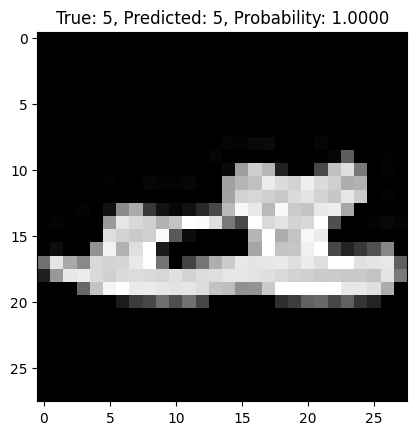

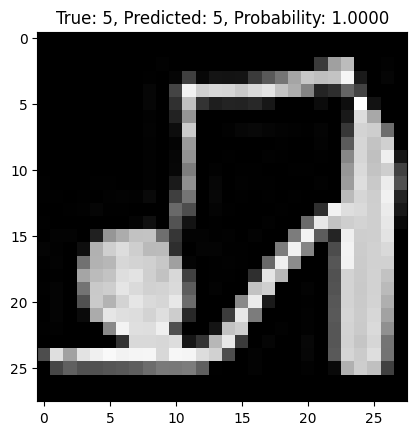

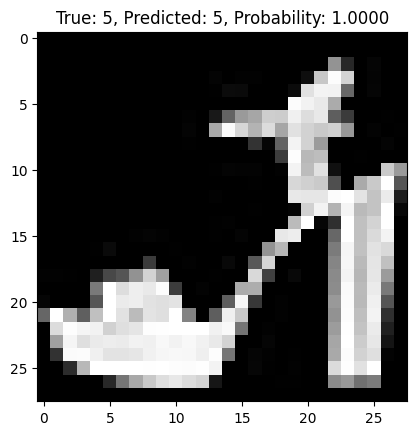

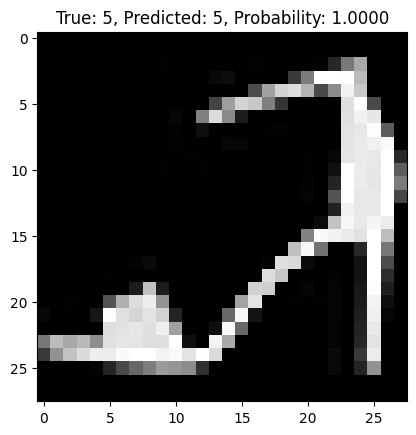

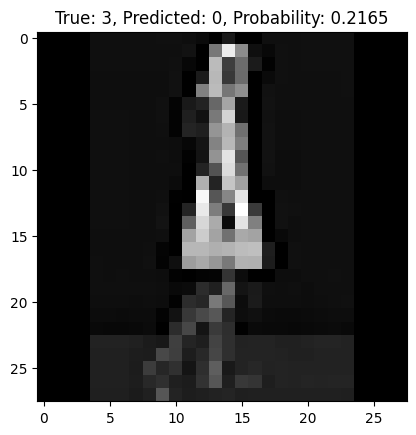

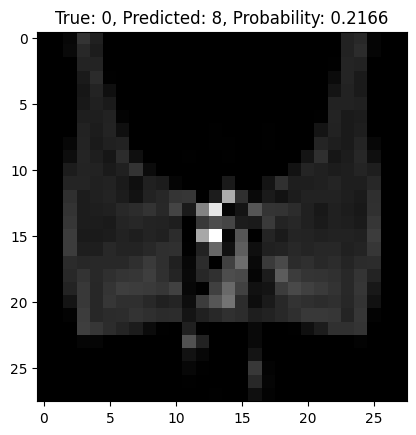

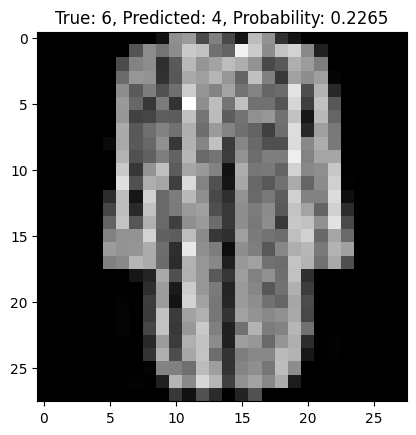

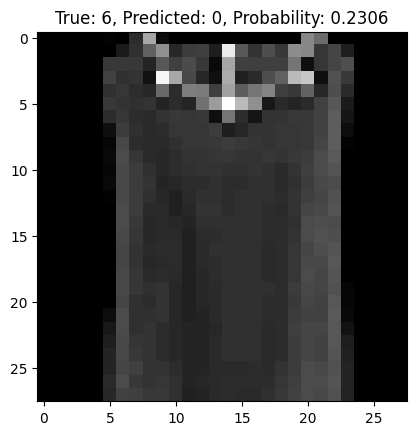

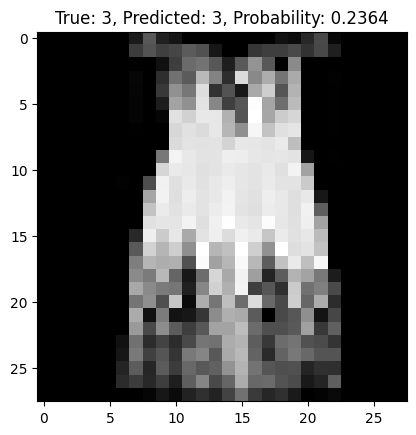

              precision    recall  f1-score   support

           0       0.79      0.94      0.86      6000
           1       1.00      0.98      0.99      6000
           2       0.82      0.86      0.84      6000
           3       0.94      0.89      0.91      6000
           4       0.77      0.91      0.83      6000
           5       0.99      0.96      0.98      6000
           6       0.89      0.58      0.70      6000
           7       0.95      0.96      0.95      6000
           8       0.98      0.97      0.98      6000
           9       0.95      0.98      0.97      6000

    accuracy                           0.90     60000
   macro avg       0.91      0.90      0.90     60000
weighted avg       0.91      0.90      0.90     60000



In [19]:
# The predicted probabilities for each class
y_pred_probs = best_model.predict(X_train)

# The corresponding predicted labels
y_pred_labels = np.argmax(y_pred_probs, axis=1)

# The corresponding true labels
y_true_labels = np.argmax(y_train, axis=1)

# A list with the maximum probabilities for each sample
y_max_probs = list(range(len(y_pred_probs)))
for i, row in enumerate(y_pred_probs):
  y_max_probs[i] = np.max(row)

# Retrieve the indices of the sorted list
indices = np.argsort(y_max_probs)

# The last five are the indices of the samples with highest predicted probabilities (most convinced)
most_convinced_indices = indices[-5:]
# The first five are the indices of the samples with lowest predicted probabilities (most confused)
most_confused_indices = indices[:5]

# Print the sample, predicted label and probability in the most convinced case
for index in most_convinced_indices:
    plt.imshow(X_train[index],cmap="gray")
    plt.title(f'True: {y_true_labels[index]}, Predicted: {y_pred_labels[index]}, Probability: {y_pred_probs[index, y_pred_labels[index]]:.4f}')
    plt.show()

# Print the sample, predicted label and probability in the most confused case
for index in most_confused_indices:
    plt.imshow(X_train[index],cmap="gray")
    plt.title(f'True: {y_true_labels[index]}, Predicted: {y_pred_labels[index]}, Probability: {y_pred_probs[index, y_pred_labels[index]]:.4f}')
    plt.show()

# Print a classification report
print(classification_report(y_true_labels, y_pred_labels))


The model exhibits more weakness in accurately predicting the upper body clothing items probably due to their high similarity in the pixel distributions, while demonstrating strength in classifying items with very distinguishable distributions like bags, trousers and shoes.

## Retraining

Now that we have seen that the model does a better job for some classes and worse for others, we want to try to improve the classification for those classes that the model struggled with most.

First of all we try to check whether the dataset was unbalanced, i.e. the number of samples for each class are not equal or anyway similar.

In [20]:
# Count the number of occurrences of 1 in each column
count = np.sum(y_train, axis=0)

# Print the count of ones for each class (column)
for class_label, sum in enumerate(count):
    print(f"Class {class_label}: samples {sum}")

Class 0: samples 6000.0
Class 1: samples 6000.0
Class 2: samples 6000.0
Class 3: samples 6000.0
Class 4: samples 6000.0
Class 5: samples 6000.0
Class 6: samples 6000.0
Class 7: samples 6000.0
Class 8: samples 6000.0
Class 9: samples 6000.0


Having seen that the dataset is perfectly balanced, we are going to apply a heuristic function that maps each class label to a weight which is inversely proportional to the accuracy that the class displayed in the evaluation of the model with the test set.

In [21]:
# Compute confusion matrix
cm = confusion_matrix(y_true_labels, y_pred_labels)

# Initialize the class_weights dictionary
class_weights = {}

# Compute accuracies and weights for each class
class_accuracies = []
for class_label in range(len(cm)):
    class_accuracy = cm[class_label, class_label] / np.sum(cm[class_label, :])
    class_accuracies.append(class_accuracy)
    # Heuristic function
    class_weights[class_label] = 1 / (class_accuracy**2)

# Print class labels along with their accuracies
for class_label, accuracy in enumerate(class_accuracies):
    print(f"Class {class_label}: Accuracy {accuracy:.2f}")

print("Class weights based on accuracy:", class_weights)

Class 0: Accuracy 0.94
Class 1: Accuracy 0.98
Class 2: Accuracy 0.86
Class 3: Accuracy 0.89
Class 4: Accuracy 0.91
Class 5: Accuracy 0.96
Class 6: Accuracy 0.58
Class 7: Accuracy 0.96
Class 8: Accuracy 0.97
Class 9: Accuracy 0.98
Class weights based on accuracy: {0: 1.1277312240582662, 1: 1.046208835605602, 2: 1.3589208567890307, 3: 1.259163518787017, 4: 1.211574535005266, 5: 1.0820616303831363, 6: 2.964127877416845, 7: 1.093024888996491, 8: 1.0522992431542308, 9: 1.0415870708491288}


Now we are going to retrain the model with the previously defined weights

Epoch 1/50
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.8961 - loss: 0.4195 - val_accuracy: 0.8731 - val_loss: 0.3466
Epoch 2/50
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - accuracy: 0.8992 - loss: 0.4042 - val_accuracy: 0.8697 - val_loss: 0.3491
Epoch 3/50
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.9055 - loss: 0.3734 - val_accuracy: 0.8691 - val_loss: 0.3501
Epoch 4/50
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - accuracy: 0.9041 - loss: 0.3821 - val_accuracy: 0.8808 - val_loss: 0.3248
Epoch 5/50
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - accuracy: 0.9088 - loss: 0.3597 - val_accuracy: 0.8840 - val_loss: 0.3234


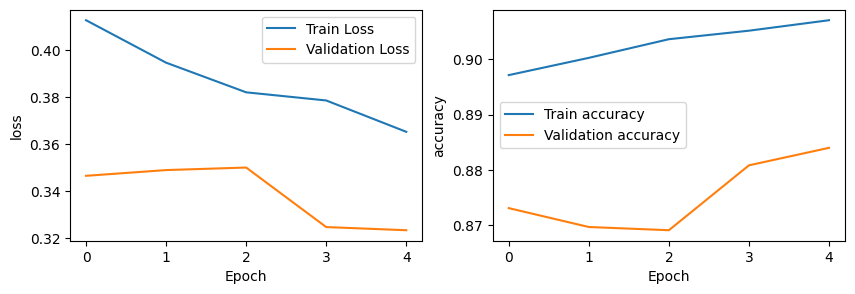

Best epoch: 5


In [22]:
retrained_model = best_model
history = retrained_model.fit(X_train, y_train, epochs=50, validation_split=0.2, class_weight=class_weights, callbacks=[stop_early])

plot_history(history)

val_acc_per_epoch = history.history['val_accuracy']
best_epoch = np.argmax(val_acc_per_epoch) + 1
print('Best epoch: %d' % (best_epoch,))

Save the retrained model in the workspace

In [27]:
retrained_model.save('/content/retrained_model.keras')

Here we display the evaluation statistics of the retrained model

In [23]:
best_score_retrained = retrained_model.evaluate(X_test, y_test, verbose=0)

print("Best model")
print("Best parameters:", best_hps.values)
print("Test loss:", best_score_retrained[0])
print("Test accuracy:", best_score_retrained[1])
print("Test accuracy improvement:", 100*(best_score_retrained[1]-best_score[1])/best_score[1], "%")

Best model
Best parameters: {'unitsL1': 448, 'unitsL2': 256, 'activation': 'relu', 'learning_rate': 0.01, 'optimizer': 'sgd', 'batch_size': 16, 'tuner/epochs': 4, 'tuner/initial_epoch': 0, 'tuner/bracket': 1, 'tuner/round': 0}
Test loss: 0.3531516194343567
Test accuracy: 0.8754000067710876
Test accuracy improvement: 0.37839825416689166 %


Here we recompute the class-wise accuracies of the retrained model and confront them with the previous model.

In [24]:
# The predicted probabilities for each class
y_pred_probs = retrained_model.predict(X_train)

# The corresponding predicted labels
y_pred_labels = np.argmax(y_pred_probs, axis=1)

# The corresponding true labels
y_true_labels = np.argmax(y_train, axis=1)

# Print the classification report
print(classification_report(y_true_labels, y_pred_labels))

# Compute confusion matrix
cm = confusion_matrix(y_true_labels, y_pred_labels)

# Compute accuracies for each class
class_accuracies_retrain = []
for class_label in range(len(cm)):
    class_accuracy = cm[class_label, class_label] / np.sum(cm[class_label, :])
    class_accuracies_retrain.append(class_accuracy)

# Print class labels along with their accuracies
for class_label, accuracy in enumerate(class_accuracies_retrain):
    print(f"Class {class_label}: Accuracy {accuracy:.2f}")

# Convert lists to numpy arrays
class_accuracies_retrain = np.array(class_accuracies_retrain)
class_accuracies = np.array(class_accuracies)

# Compute the difference between the accuracies
class_accuracies_diff = class_accuracies_retrain - class_accuracies

# Print the accuracy difference for each class
for class_label, diff in enumerate(class_accuracies_diff):
    print(f"Class {class_label}: Accuracy Increment {diff:.2f}")

1875/1875 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step
              precision    recall  f1-score   support

           0       0.91      0.84      0.87      6000
           1       0.99      0.98      0.99      6000
           2       0.80      0.90      0.85      6000
           3       0.93      0.91      0.92      6000
           4       0.82      0.88      0.84      6000
           5       0.99      0.97      0.98      6000
           6       0.81      0.73      0.77      6000
           7       0.92      0.99      0.95      6000
           8       0.99      0.97      0.98      6000
           9       0.99      0.94      0.96      6000

    accuracy                           0.91     60000
   macro avg       0.91      0.91      0.91     60000
weighted avg       0.91      0.91      0.91     60000

Class 0: Accuracy 0.84
Class 1: Accuracy 0.98
Class 2: Accuracy 0.90
Class 3: Accuracy 0.91
Class 4: Accuracy 0.88
Class 5: Accuracy 0.97
Class 6: Accuracy 0.73
Class 7: Accuracy 0.99
Class 8: Accur